In [29]:
# import
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import numpy as np
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
import random
import cv2
from scipy import signal
import os
# from skimage.morphology import skeletonize, thin
import math
from PIL import Image, ImageOps

In [30]:

# Import
template =  Image.open("crewmate/idle.png")
walk1 =  Image.open("crewmate/Walk0001.png")
walk11 =  Image.open("crewmate/Walk0011.png")
walk6 =  Image.open("crewmate/Walk0006.png")
red = Image.open("crewmate/Red.png")
yellow = Image.open("crewmate/Yellow.png")
cyan = Image.open("crewmate/Cyan.png")
black = Image.open("crewmate/Black.png")

In [31]:
# Constants

# BODY PANTS MASK SHADOW REFELCTION
template_rgb = np.array([[255,16,16],[0,0,255],[0,255,0]])
bpm = np.array([[100,100],[150,60],[50,110]])

In [32]:

def show(imgs):
    for img in imgs:
        plt.imshow(img)
        plt.show()
        
def countUniquePixels(img):
    x = np.array(img)
    x = x.reshape(-1,x.shape[-1])
    return np.unique(x,return_counts=True,axis=0)

def makeDictFromLists(test_keys, test_values):
    test_keys = list(test_keys)
    test_values = list(test_values)
    res = {}
    for key in test_keys:
        for value in test_values:
            res[key] = value
            test_values.remove(value)
            break
    return res

def getTopPixels(img,top):
    pixel, count = countUniquePixels(img)
    count = count.reshape(-1,1)
    #print(111,pixel,count)
    arr = np.concatenate((count,pixel),axis=1)
    arr = arr[arr[:, 0].argsort()]
    return arr[::-1][:top:]

def showTopPixels(img):
    img = img[None,::,1::]
    show([img])

def showPixels(img,xy):
    arr = np.array(img)
    ans = []
    inner = []
    for x,y in xy:
        inner.append(arr[x][y][:3:])
    ans.append(inner)
    print("ANS",ans)
    show([ans])

# Ax = b >>> A = bx'
# from:x, to:b
def getMatrix(x,b):
    x=np.array(x)
    b=np.array(b)
    b = b.reshape(-1,b.shape[-1]).T
    x = x.reshape(-1,x.shape[-1]).T
    #print("b",b)
    #print("x",x)
    matrix = np.matmul(b,np.linalg.pinv(x))
    return matrix

def getRGB(img,xy):
    arr = np.array(img)
    ans = []
    inner = []
    for x,y in xy:
        inner.append(arr[x][y][:3:])
    # reflection and shadow
    ans.append(inner)
    return ans

def isCloseToTemplate(rgb):
    rgb = np.array(rgb)
    r = np.array([255,16,16])
    g = np.array([0,255,0])
    b = np.array([0,0,255])
    threshold = 265
    return np.sum(np.abs(rgb - r)) <= threshold or np.sum(np.abs(rgb - g)) <= threshold or np.sum(np.abs(rgb - b)) <= threshold

def transferColor(template, color_img):
    new_img = np.array(template)[::,::,:3:]
    template_arr = np.array(template)[::,::,:3:]
    color_arr = np.array(color_img)
    color_arr = color_arr[::,::,:3:]
    trgb = np.array([[255,16,16],[0,0,255],[0,255,0]])
    crgb = getRGB(color_img,bpm)
    #print(trgb,crgb)
    A = getMatrix(trgb,crgb)
    #print("A",A)
    #print("color arr", color_arr)
    for i in range(len(new_img)):
        for j in range(len(new_img[i])):
            if isCloseToTemplate(template_arr[i][j]):
                new_img[i][j]= A @ template_arr[i][j]
    new_img = make000Transparent(new_img)
    return new_img

def make000Transparent(img):
    x = np.array(img)
    b = np.ones((x.shape[0],x.shape[1] , 1), dtype="uint8") * 255
    z = np.concatenate((x,b), axis = 2)
    idx = (z==[0,0,0,255]).all(axis=2)
    z[idx] = [0,0,0,0]
    return z

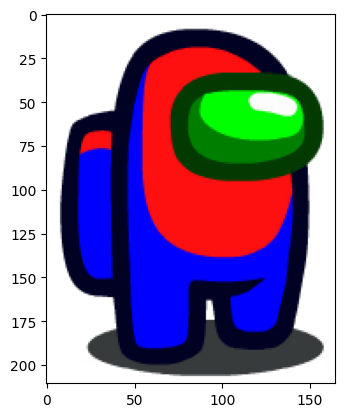

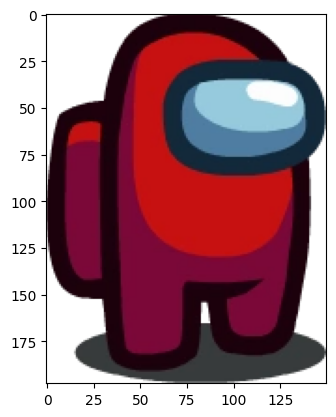

[[10857     0     0     0]
 [ 5536     1     1    35]
 [ 4526     0     0   255]
 [ 4407   255    16    16]
 [ 1987     2    58     2]
 [ 1156    55    59    60]
 [  873     0   126     0]
 [  849     0   255     0]
 [  458     0     0   254]
 [  241   254    16    16]]


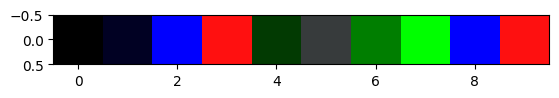

[[3556    0    0    0]
 [3520  199   17   17]
 [2811  123    8   56]
 [2201   28    1   12]
 [1058   55   59   60]
 [ 599   19   41   58]
 [ 580  150  202  221]
 [ 501   30    0   12]
 [ 477   26    2   12]
 [ 399   79  125  162]]


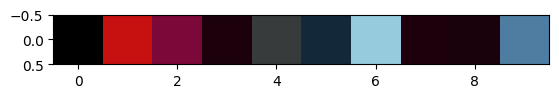

ANS [[array([255,  16,  16], dtype=uint8), array([  0,   0, 255], dtype=uint8), array([  0, 255,   0], dtype=uint8)]]


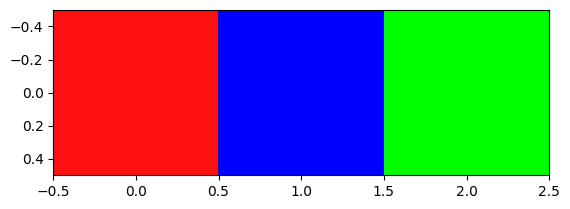

ANS [[array([199,  17,  17], dtype=uint8), array([123,   8,  56], dtype=uint8), array([150, 202, 221], dtype=uint8)]]


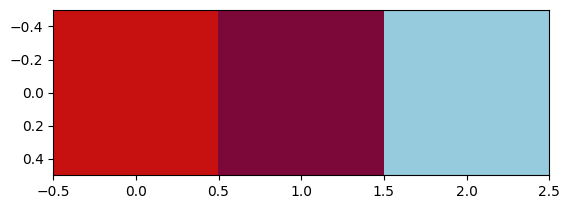

In [33]:
show([template,red])
template_original = np.array(template)
template_arr = np.array(template_original[::,::,:-1:])
red_original = np.array(red)
red_arr = np.array(red_original[::,::,:-1:])
# print(countUniquePixels(template_arr))
template_colors = getTopPixels(template_arr,10)
print(template_colors)
showTopPixels(template_colors)
red_colors = getTopPixels(red_arr,10)
print(red_colors)
showTopPixels(red_colors)
#print(countUniquePixels(red_arr))
#print(countUniquePixels(red_original))
showPixels(template,bpm)
showPixels(red,bpm)

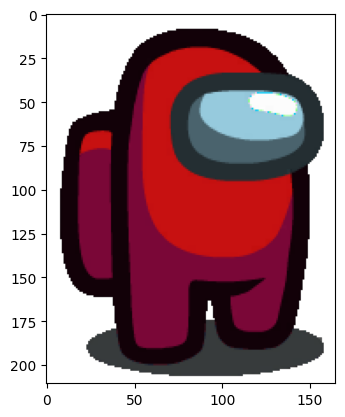

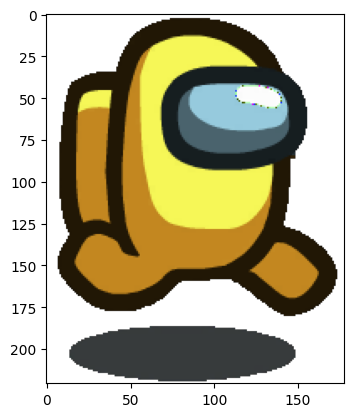

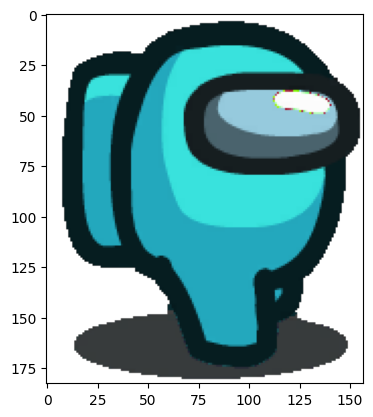

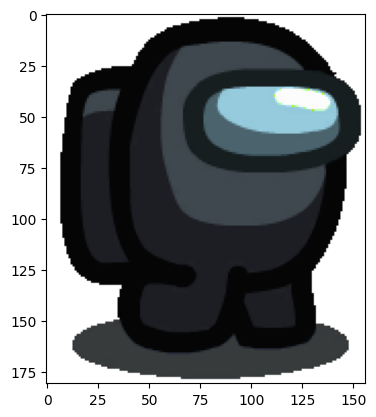

In [34]:
show([transferColor(template,red)])
show([transferColor(walk1,yellow)])
show([transferColor(walk11,cyan)])
show([transferColor(walk6,black)])

In [35]:
x  = np.array([
               [[1,2],[3,4]],
               [[5,6],[7,8]],
               [[1,2],[3,40]]
               ])

x = x.reshape(-1,x.shape[-1])
un = np.unique(x,return_counts=True,axis=0)
#print(un)

def getTopPixels(img,top):
    pixel, count = countUniquePixels(img)
    count = count.reshape(-1,1)
    #print(111,pixel,count)
    arr = np.concatenate((count,pixel),axis=1)
    arr = arr[arr[:, 0].argsort()]
    return arr[::-1][:top:]
y = np.array([[1,2,3],[4,6,5],[0,1,2],[4,6,5],[4,6,5],[0,1,2]])
print(getTopPixels(y,10))
#print(y)

[[3 4 6 5]
 [2 0 1 2]
 [1 1 2 3]]


In [36]:
x = np.array([
    [[1,2],[0,0]],
    [[2,3],[0,0]]
    ])



b = np.ones((x.shape[0],x.shape[1] , 1), dtype="uint8") * 255
print(x,b)
z = np.concatenate((x,b), axis = 2)
print(z)
idx = (z==[0,0,255]).all(axis=2)
print(idx)
z[idx] = [0,0,0]
print(z)

[[[1 2]
  [0 0]]

 [[2 3]
  [0 0]]] [[[255]
  [255]]

 [[255]
  [255]]]
[[[  1   2 255]
  [  0   0 255]]

 [[  2   3 255]
  [  0   0 255]]]
[[False  True]
 [False  True]]
[[[  1   2 255]
  [  0   0   0]]

 [[  2   3 255]
  [  0   0   0]]]


In [69]:
x = [1,2,3,4,5]
print(random.choice(x))

5
